# 1️⃣ Brazilian Ecommerce Landscape 2016-2018
This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

# 2️⃣ Data Scoping
## Context
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

## Big Question:  
How do operations, customer experience, and purchasing behaviors influence Olist’s profitability and growth in Brazilian e-commerce?

## Key objectives to address:
1. How many of our orders actually gets delivered?
2. How did Olist perform over time?
3. How many orders were delivered on time?
4. Do late deliveries affect review scores?
5. Where do our customers come from?
6. Do customers purchase again?
7. When do customers buy?
8. Which product category drives the most revenue?
9. Which product category has most cancellations?
10. Which payment methods are most popular?
11. Which payment methods have the highest order value?

## Hypothesis
1. "Orders delivered late have significantly lower review scores compared to on-time deliveries.”

## 1) Algorithmic Thinking

Here I outline the logical steps I plan to follow:

1. Load datasets and inspect structure  
2. Clean missing values & handle invalid data  
3. Transform and join datasets into analysis-ready tables  
4. Explore delivery performance vs customer reviews  
5. Explore sales drivers (categories, regions, payment types)  
6. Summarize insights and actionable recommendations  

## 2) Data Loading

In [23]:
#libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns",100)

In [24]:
#Reading all the files
customers = pd.read_csv("data/olist_customers_dataset.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")
product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")


### Before creating a unique dataset, let's check for missing values. 

In [25]:
#Check for missing values
datasets = {
    "customers": customers,
    "geolocation": geolocation,
    "order_items": order_items,
    "order_payments": order_payments,
    "order_reviews": order_reviews,
    "orders": orders,
    "products": products,
    "sellers": sellers
}

for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(df.isnull().sum())
    print("-" * 40)


Dataset: customers
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
----------------------------------------
Dataset: geolocation
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
----------------------------------------
Dataset: order_items
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
----------------------------------------
Dataset: order_payments
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
----------------------------------------
Dataset: order_reviews
review_id                      0
order_id               

In [26]:
# To summarize
def dataset_summary(datasets_dict):
    summary = []
    for name, df in datasets_dict.items():
        null_counts = df.isnull().sum()
        null_cols = null_counts[null_counts > 0].index.tolist()
        
        summary.append({
            "dataset": name,
            "n_rows": df.shape[0],
            "n_cols": df.shape[1],
            "null_amount": df.isnull().sum().sum(),
            "qty_null_columns": len(null_cols),
            "null_columns": ", ".join(null_cols)
        })
    
    return pd.DataFrame(summary)

# Run it
summary_table = dataset_summary(datasets)
summary_table

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,customers,99441,5,0,0,
1,geolocation,1000163,5,0,0,
2,order_items,112650,7,0,0,
3,order_payments,103886,5,0,0,
4,order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
5,orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_dat..."
6,products,32951,9,2448,8,"product_category_name, product_name_lenght, pr..."
7,sellers,3095,4,0,0,


#### There are 3 datasets that contain missing values. 
1) order_reviews
2) products
3) orders

#### Missing timestamps in orders mean the orders never reached that stage

In [27]:
# For example:
#order_approved_at missing → order might have been canceled before approval

#order_delivered_carrier_date missing → order never shipped

#order_delivered_customer_date missing → order never delivered

#Data Cleaning, removing duplicates and null values from the dataframe



## 3) Data Cleaning 

#### Order Reviews Data
There's **no missing `review score`**, which is great. This critical data helps us to determine customer satisfaction. However, I spotted many missing values in `review_comment_title` and `review_comment_message`. This is likely because many customers leave only a **star rating** without text. I will keep the rows, replace missing text fields with empty strings `""` for consistency.

In [28]:
# Check for nulls
print("Before cleaning:")
print(order_reviews.isnull().sum())

Before cleaning:
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


In [29]:
# 1. Drop rows where review_score is missing (none, but just in case)
order_reviews = order_reviews.dropna(subset=["review_score"])

# 2. Replace NaN in comment columns with empty string
order_reviews["review_comment_title"] = order_reviews["review_comment_title"].fillna("")
order_reviews["review_comment_message"] = order_reviews["review_comment_message"].fillna("")

# Verify cleaning
print("\nAfter cleaning:")
print(order_reviews.isnull().sum())

# Save cleaned dataset
order_reviews.to_csv("olist_order_reviews_cleaned.csv", index=False)


After cleaning:
review_id                  0
order_id                   0
review_score               0
review_comment_title       0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64


#### Products Data
There's no missing `product id` which is great. However, `product_category_name` is missing for some products. I have replace them with `unknown category` for consistency. Additionally, `product_name_lenght`,` product_description_lenght` and `product_photos_qty` are missing 610 rows each. I have replaced them with `0` signifiying no records, not available).

Moreover, I have imputed with the **median value of the same category** for the missing product dimensions data. These includes `product_weight_g`, `product_length_cm`, `product_height_cm`, `product_width_cm`. There are only 2 missing values, so I doubt it will be affect the overall dataset.

In [30]:
# Check for nulls
print("Before cleaning:")
print(products.isnull().sum())

Before cleaning:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [31]:
# 1. Handle product_category_name
products['product_category_name'] = products['product_category_name'].fillna("unknown_category")

# 2. Handle product_photos_qty (replace null with 0)
products["product_name_lenght"] = products["product_name_lenght"].fillna(0).astype(int)
products["product_description_lenght"] = products["product_description_lenght"].fillna(0).astype(int)

# 3. Handle product dimensions & weight
dimension_cols = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

# Drop rows where ALL dimension values are null, and make a copy
products = products.dropna(subset=dimension_cols, how='all').copy()

# For partial nulls, impute with median per category
for col in dimension_cols:
    products[col] = products.groupby('product_category_name')[col].transform(
        lambda x: x.fillna(x.median())
    )

# If still null after group median (e.g. category all missing), fill with global median
for col in dimension_cols:
    products[col] = products[col].fillna(products[col].median())

# Verify cleaning
print("After cleaning:")
print(products.isnull().sum())


After cleaning:
product_id                      0
product_category_name           0
product_name_lenght             0
product_description_lenght      0
product_photos_qty            609
product_weight_g                0
product_length_cm               0
product_height_cm               0
product_width_cm                0
dtype: int64


In [32]:
# Handle product_name_lenght and product_description_lenght
products['product_name_lenght'] = products['product_name_lenght'].fillna(0).astype(int)
products['product_description_lenght'] = products['product_description_lenght'].fillna(0).astype(int)

# Save cleaned dataset
products.to_csv("olist_products_cleaned.csv", index=False)

#### Orders data
The 3 main key identifiers `order_id`, `customer_id`, `order_status` are not missing any values which is great. 

However, I found that there are 160 missing values for `order_approved_at`. **This null values are normal**. could mean 2 things that needs further analysis:
1) For **cancelled/unavailable orders**, approval never happens → missing is valid.  
2) For **delivered/shipped orders**, missing approval may indicate incomplete data.  

Besides, there were a lot of missing values in `order_delivered_carrier_date` & `order_delivered_customer_date`. Missing values indicate that the orders **were never shipped (cancelled/ unavailable)**.

In [33]:
# Check nulls before cleaning
print("Before cleaning:")
orders.isnull().sum()

Before cleaning:


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

#### New columns in Orders data
My approach to the missing values is no imputation — instead create a new flag column (`expected_null`) to distinguish **valid nulls** (cancelled orders) from **unexpected nulls** (data errors). So, I have added **new columns** that will be useful for data joining and analysis

1) `expected_null` =TRUE if missing delivery dates are *valid* (e.g., order cancelled/unavailable). FALSE if an order is marked "delivered" but missing delivery date (possible data error).  
2) `delay_days` = Positive = delivered late; Zero or negative = delivered on time/early 
4) `on_time_flag` = TRUE if delivered on/before estimate, FALSE if late
5) `purchase month` = extracted from timestamp, helps to visualise GMV per month later

In [34]:
# Convert to datetime
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

# Create flag for whether missing dates are expected
def expected_null(row):
    if row["order_status"] in ["canceled","unavailable"]:
        return True  # valid missing values
    return False

orders["expected_null"] = orders.apply(expected_null, axis=1)

# Create delay_days (only for delivered orders)
orders["delay_days"] = (
    orders["order_delivered_customer_date"] - orders["order_estimated_delivery_date"]
).dt.days

# On-time flag (True if delivered on/before estimate, False if late)
orders["on_time_flag"] = orders["delay_days"] <= 0

# Make a simple "purchase_month" column for grouping by month later
orders["purchase_month"] = orders["order_purchase_timestamp"].dt.to_period("M").astype(str)

In [35]:
#Verify cleaning
print("After cleaning:")
orders.isnull().sum()

After cleaning:


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
expected_null                       0
delay_days                       2965
on_time_flag                        0
purchase_month                      0
dtype: int64

#### Saved Cleaned CSV Files into Folder

In [36]:
# Save Orders dataset (after cleaning)
orders.to_csv("olist_orders_cleaned.csv", index=False)

# Save Products dataset (after cleaning & translation)
products.to_csv("olist_products_cleaned.csv", index=False)

# Save Reviews dataset (after cleaning)
order_reviews.to_csv("olist_order_reviews_cleaned.csv", index=False)

# (Optional) Save joined translations separately
product_category_name_translation.to_csv("product_category_translation_cleaned.csv", index=False)

print("✅ Cleaned datasets saved as CSV files with '_cleaned' suffix.")


✅ Cleaned datasets saved as CSV files with '_cleaned' suffix.


## 3b) Data joining
I combined cleaned Orders, Order Items (sales), Customers (state), Reviews (satisfaction), and Payments (payment type) into **one analysis-ready table (`orders_EDA`)**.  

This ensures each row = one order, and I can now explore **sales trends, customer states, payment preferences, and reviews** all in one place.

In [39]:
# --- 1) Start from orders (already cleaned) ---
orders_EDA = orders[[
    "order_id","customer_id","order_status",
    "order_purchase_timestamp","purchase_month",
    "delay_days","on_time_flag"
]].copy()

# --- 2) Aggregate order_items to order-level totals ---
order_values = (
    order_items.groupby("order_id", as_index=False)
    .agg(
        order_value=("price","sum"),
        freight_value=("freight_value","sum"),
        items_count=("order_item_id","count")
    )
)

# Merge aggregated order values
orders_EDA = orders_EDA.merge(order_values, on="order_id", how="left")

# --- 3) Add customer info ---
orders_EDA = orders_EDA.merge(
    customers[["customer_id","customer_unique_id","customer_state"]],
    on="customer_id", how="left"
)

# --- 4) Add review score ---
orders_EDA = orders_EDA.merge(
    order_reviews[["order_id","review_score"]],
    on="order_id", how="left"
)

# --- 5) Add payment type ---
orders_EDA = orders_EDA.merge(
    order_payments[["order_id","payment_type","payment_value"]],
    on="order_id", how="left"
)

# --- 6) Add a total revenue column ---
orders_EDA["total_revenue"] = orders_EDA["order_value"].fillna(0) + orders_EDA["freight_value"].fillna(0)

# --- Quick check ---
print("Rows:", len(orders_EDA))
print("Unique orders:", orders_EDA["order_id"].nunique())
orders_EDA.head()


Rows: 104478
Unique orders: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,purchase_month,delay_days,on_time_flag,order_value,freight_value,items_count,customer_unique_id,customer_state,review_score,payment_type,payment_value,total_revenue
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10,-8.0,True,29.99,8.72,1.0,7c396fd4830fd04220f754e42b4e5bff,SP,4.0,credit_card,18.12,38.71
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10,-8.0,True,29.99,8.72,1.0,7c396fd4830fd04220f754e42b4e5bff,SP,4.0,voucher,2.00,38.71
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10,-8.0,True,29.99,8.72,1.0,7c396fd4830fd04220f754e42b4e5bff,SP,4.0,voucher,18.59,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07,-6.0,True,118.70,22.76,1.0,af07308b275d755c9edb36a90c618231,BA,4.0,boleto,141.46,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08,-18.0,True,159.90,19.22,1.0,3a653a41f6f9fc3d2a113cf8398680e8,GO,5.0,credit_card,179.12,179.12


In [40]:
# Save joined orders_EDA separately
orders_EDA.to_csv("orders_EDA.csv", index=False)

print("✅ Cleaned datasets joined and saved as CSV files with '_EDA' suffix.")

✅ Cleaned datasets joined and saved as CSV files with '_EDA' suffix.


## 4️⃣ Exploratory Data Analysis
The EDA is conducted based on my key objectives. These findings correlates with each other and is key to understanding Olist ecommerce landscape.

1) How many of our orders actually gets delivered?
2) How did Olist perform over time?
3) How many orders were delivered on time?
4) Do late deliveries affect review scores?
5) Where do our customers come from?
6) Do customers purchase again?
7) When do customers buy?
8) Which product category drives the most revenue?
9) Which product category has most cancellations?
10) Which payment methods are most popular?
11) Which payment methods have the highest order value?

### 1. How many of our orders actually gets delivered? 
By the time this dataset was created, the highest amount of orders came from **delivered ones (97%)**. Only **3%** of all orders came from the other status.


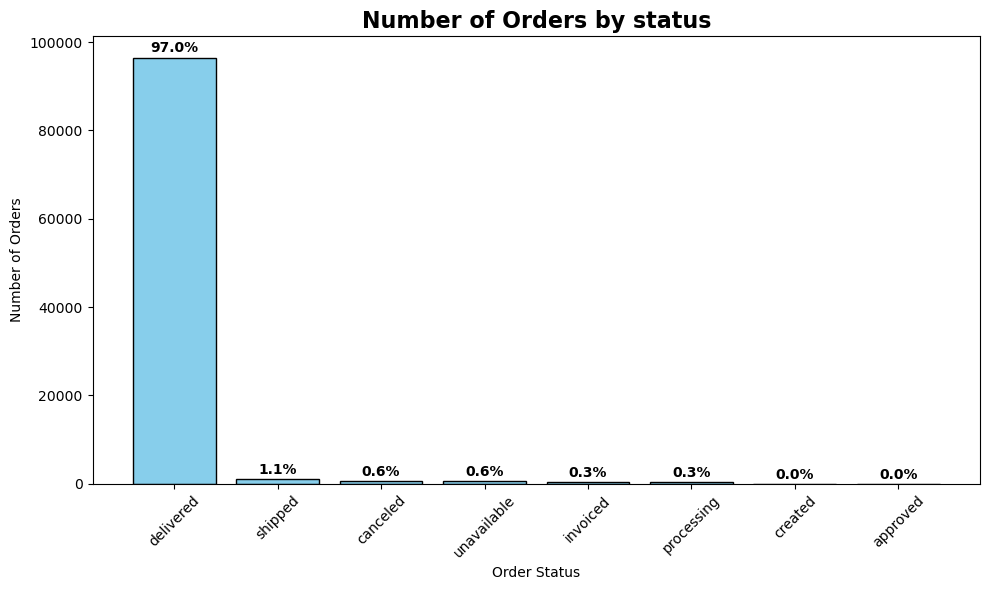

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Count order statuses
status_counts = orders['order_status'].value_counts()
status_percent = (status_counts / status_counts.sum()) * 100

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(status_counts.index, status_counts.values, 
               color='skyblue', edgecolor='black')

# Add percentages on bars
for bar, count, pct in zip(bars, status_counts.values, status_percent):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 500,   # move text slightly above bar
             f"{pct:.1f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
plt.xlabel("Order Status")
plt.ylabel("Number of Orders")
plt.title("Number of Orders by status", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### 2. How did Olist perform over time?
#### By the chart below I can conclude:

E-commerce on Brazil really has a growing trend along the time. I can see some seasonality with peaks at specific months, but in general I can see clear that customers are more prone to buy things online than before. I noticed that **November 2017** recorded the highest GMV, followed by **January, March, April 2018**.

A few extra things I found out are:
**AOV**: 119.00 (in brazilian real)
**Highest AOV**: 152.29 (in brazilian real)

In [44]:
monthly = (
    orders_EDA
    .groupby("purchase_month", as_index=False)
    .agg(
        orders_count=("order_id", "count"),
        gmv=("order_value", "sum")
    )
)

# Average Order Value (AOV) = GMV / Orders
monthly["aov"] = (monthly["gmv"] / monthly["orders_count"]).round(2)

monthly.describe()


,orders_count,gmv,aov
count,25.000000,2.500000e+01,25.000000
mean,4179.120000,5.709480e+05,119.572400
std,2811.338135,3.817789e+05,45.488002
min,1.000000,0.000000e+00,0.000000
25%,1894.000000,2.620139e+05,130.600000
50%,4544.000000,6.060270e+05,136.350000
75%,6700.000000,9.100530e+05,142.540000
max,7933.000000,1.055072e+06,152.290000


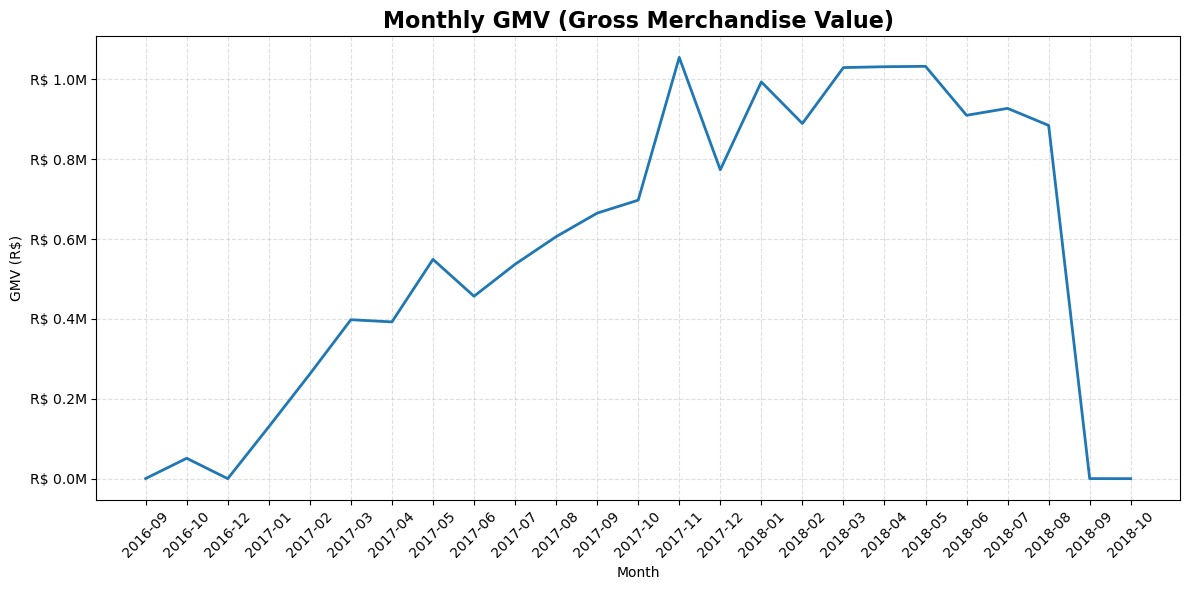

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Sort months correctly
monthly_plot = monthly.copy()
monthly_plot["month_dt"] = pd.to_datetime(monthly_plot["purchase_month"])
monthly_plot = monthly_plot.sort_values("month_dt")

# Brazilian Real (BRL) currency formatter, e.g. R$ 1.234.567
def brl_millions(x, pos):
  return f"R$ {x/1e6:.1f}M"

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(monthly_plot["purchase_month"], monthly_plot["gmv"], linewidth=2)
ax.set_title("Monthly GMV (Gross Merchandise Value)", fontsize=16, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("GMV (R$)")
ax.ticklabel_format(useOffset=False, style="plain", axis="y")
ax.yaxis.set_major_formatter(FuncFormatter(brl_millions))

plt.xticks(rotation=45)
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### 3. How many orders were delivered on time?
From the graph below, I can conclude that **90.5% of deliveries arrived on-time**. Olist needs to figure our what is causing the **10% late deliveries**.

In [46]:
# Count delivered orders by on_time_flag
counts = orders_EDA["on_time_flag"].value_counts()
perc = orders_EDA["on_time_flag"].value_counts(normalize=True) * 100
labels = ["On Time", "Late"]

print("On-Time Deliveries:", counts[True], f"({perc[True]:.1f}%)")
print("Late Deliveries:", counts[False], f"({perc[False]:.1f}%)")


On-Time Deliveries: 94508 (90.5%)
Late Deliveries: 9970 (9.5%)


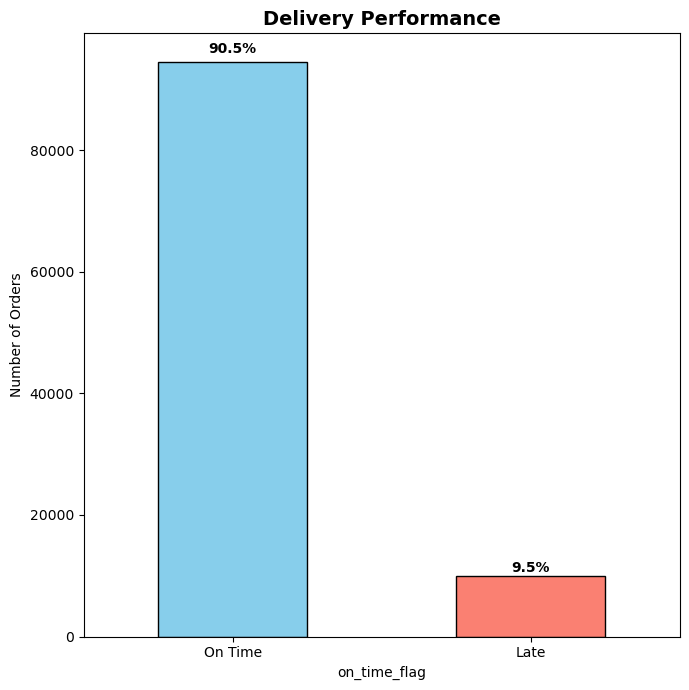

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
bars = counts.plot(kind="bar", color=["skyblue","salmon"], edgecolor="black")

plt.xticks([0,1], labels, rotation=0)
plt.title("Delivery Performance", fontsize=14, fontweight="bold")
plt.ylabel("Number of Orders")

# Add % labels on top
for bar, pct in zip(bars.patches, perc.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,      # x position
        bar.get_height() + (bar.get_height()*0.01),  # just above bar
        f"{pct:.1f}%", 
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.show()


### 4. Do delivery delays affect review scores?
Yes, very clearly I can see that the **late orders received an average review score of 2.11 out of 5** while the **on-time deliveries received an average review score of 4.29**. This further explains why Olist needs to improve their logistics/ delivery performance.

In [50]:
# Make a label column for clarity
def label_on_time(x):
    if pd.isna(x):
        return "Not Delivered"
    return "On Time" if x else "Late"

orders_EDA["on_time_label"] = orders_EDA["on_time_flag"].apply(label_on_time)

review_summary = (
    orders_EDA
    .groupby("on_time_label", as_index=False)
    .agg(
        orders=("order_id", "count"),
        avg_review=("review_score", "mean")
    )
)
review_summary["avg_review"] = review_summary["avg_review"].round(2)
review_summary


,on_time_label,orders,avg_review
0,Late,9970,2.11
1,On Time,94508,4.29


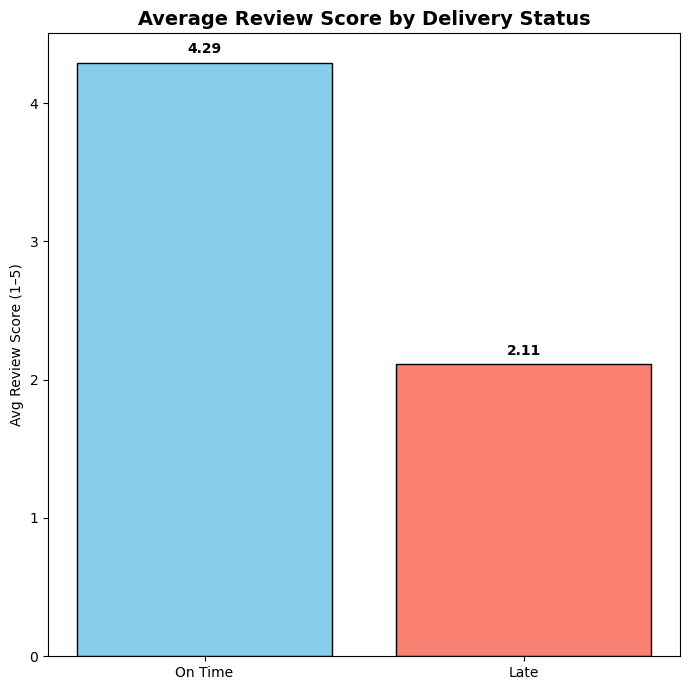

In [51]:
import matplotlib.pyplot as plt

# Reorder for consistent display
order = ["On Time", "Late"]
plot_data = review_summary[review_summary["on_time_label"].isin(order)].set_index("on_time_label").reindex(order)

# Simple bar chart
plt.figure(figsize=(7,7))
bars = plt.bar(plot_data.index, plot_data["avg_review"], color=["skyblue","salmon"], edgecolor="black")

plt.title("Average Review Score by Delivery Status", fontsize=14, fontweight="bold")
plt.ylabel("Avg Review Score (1–5)")
plt.xticks(rotation=0)

# Add labels on top
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.05,
        f"{bar.get_height():.2f}",
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.show()


### 5. Where do our customers come from?
High GMV customers are all coming from **Southeast region** (Sao Paolo, Rio de Janaeiro, Minas Gerais). They represent 60% of Olist total revenue. **South region represents an expansion opportunity** as they are ranked 4th, 5th and 6th. Additionally, the states in **North region** contribute only 0.27% of GMV but has a higher AOV. This is likely due to higher shipping fees. Olist should address these logistics gaps in North by **setting up more warehouses in the North and Center West regions** to unlock new revenue streams.

In [65]:
# Sort states by GMV (highest first)
sales_by_state = (
    orders_EDA
    .groupby("customer_state", as_index=False)
    .agg(
        orders=("order_id","count"),
        gmv=("order_value","sum")
    )
    .sort_values("gmv", ascending=False)
)

# Calculate GMV share per state
total_gmv = sales_by_state["gmv"].sum()
sales_by_state["gmv_pct"] = (sales_by_state["gmv"] / total_gmv * 100).round(2)

# Contribution of top 3 states
top3_contrib = sales_by_state.head(3)["gmv_pct"].sum().round(2)

print("Top 3 states contribute:", f"{top3_contrib}% of total GMV")
print(sales_by_state.head(10).to_string(index=False))

Top 3 states contribute: 63.36% of total GMV
customer_state  orders        gmv  gmv_pct
            SP   43865 5477008.74    38.37
            RJ   13614 1921752.53    13.46
            MG   12173 1645847.27    11.53
            RS    5708  791716.84     5.55
            PR    5283  708794.22     4.97
            BA    3627  543243.99     3.81
            SC    3770  539896.20     3.78
            DF    2224  315122.29     2.21
            GO    2131  313198.27     2.19
            ES    2117  284771.30     2.00


In [67]:
# Sort states by Lowest GMV
sales_by_state = (
    orders_EDA
    .groupby("customer_state", as_index=False)
    .agg(
        orders=("order_id","count"),
        gmv=("order_value","sum")
    )
    .sort_values("gmv", ascending=True)
)

# Calculate GMV share per state
total_gmv = sales_by_state["gmv"].sum()
sales_by_state["gmv_pct"] = (sales_by_state["gmv"] / total_gmv * 100).round(2)

# Contribution of top 3 states
top3_contrib = sales_by_state.head(3)["gmv_pct"].sum().round(2)

print("Lowest 3 states contribute:", f"{top3_contrib}% of total GMV")
print(sales_by_state.head(10).to_string(index=False))

Lowest 3 states contribute: 0.27% of total GMV
customer_state  orders      gmv  gmv_pct
            RR      46  7829.43     0.05
            AP      70 13654.30     0.10
            AC      84 17059.44     0.12
            AM     155 22865.26     0.16
            RO     261 46964.03     0.33
            TO     301 56251.91     0.39
            SE     361 60954.60     0.43
            AL     431 83314.32     0.58
            PI     525 92227.70     0.65
            RN     524 94607.86     0.66


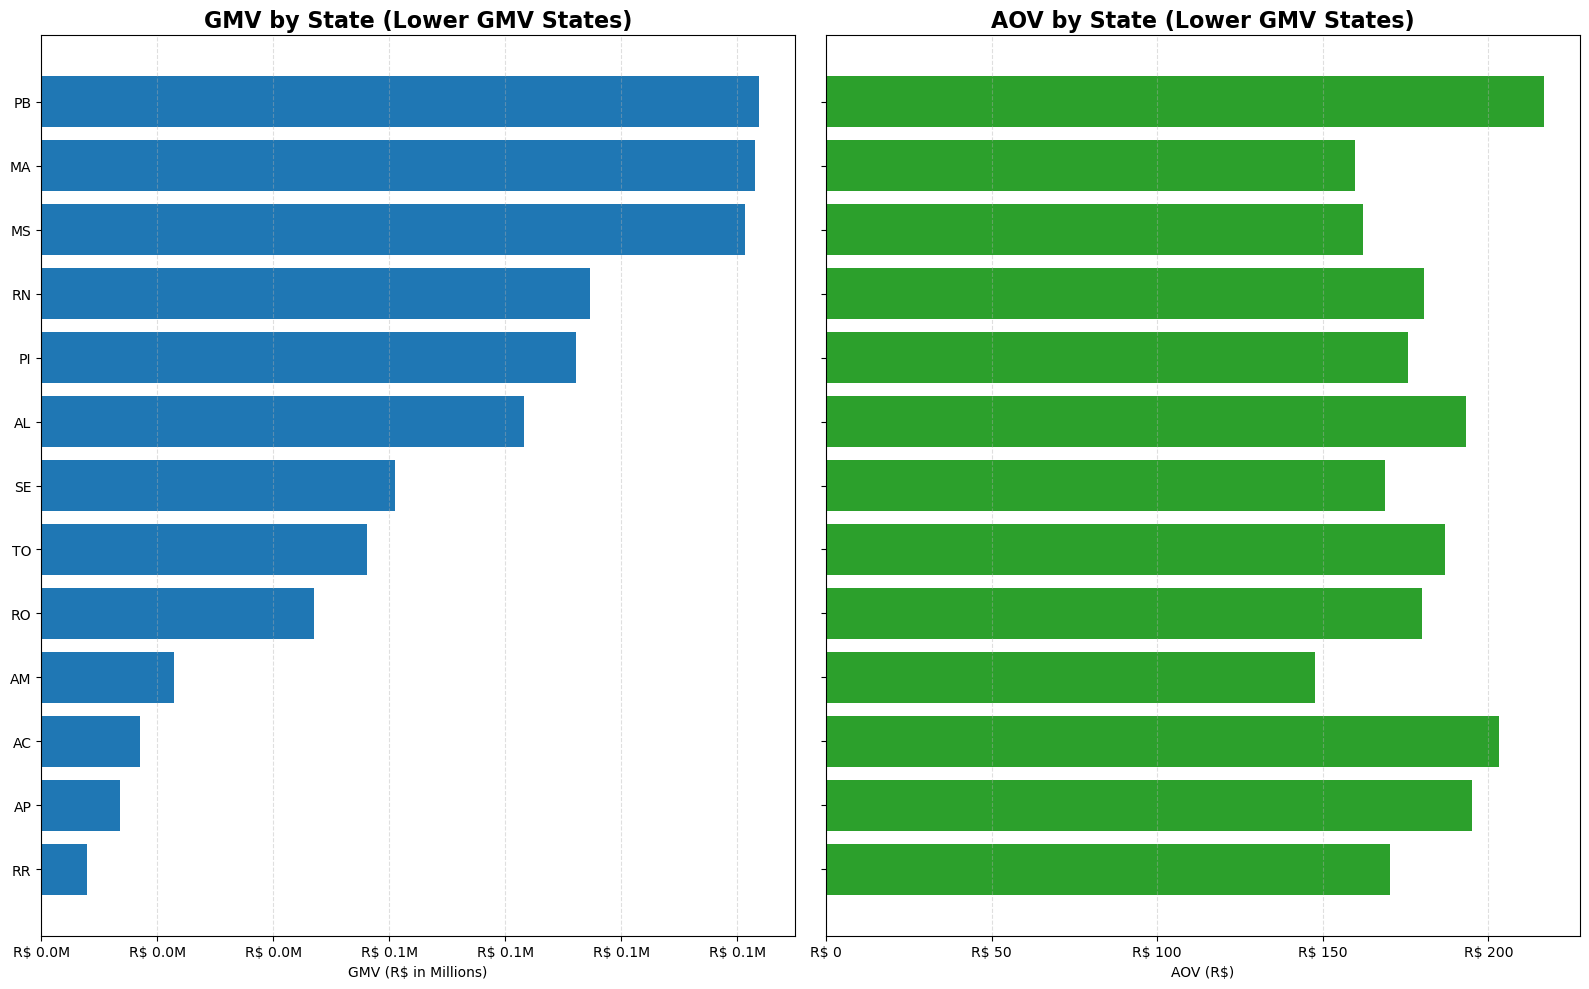

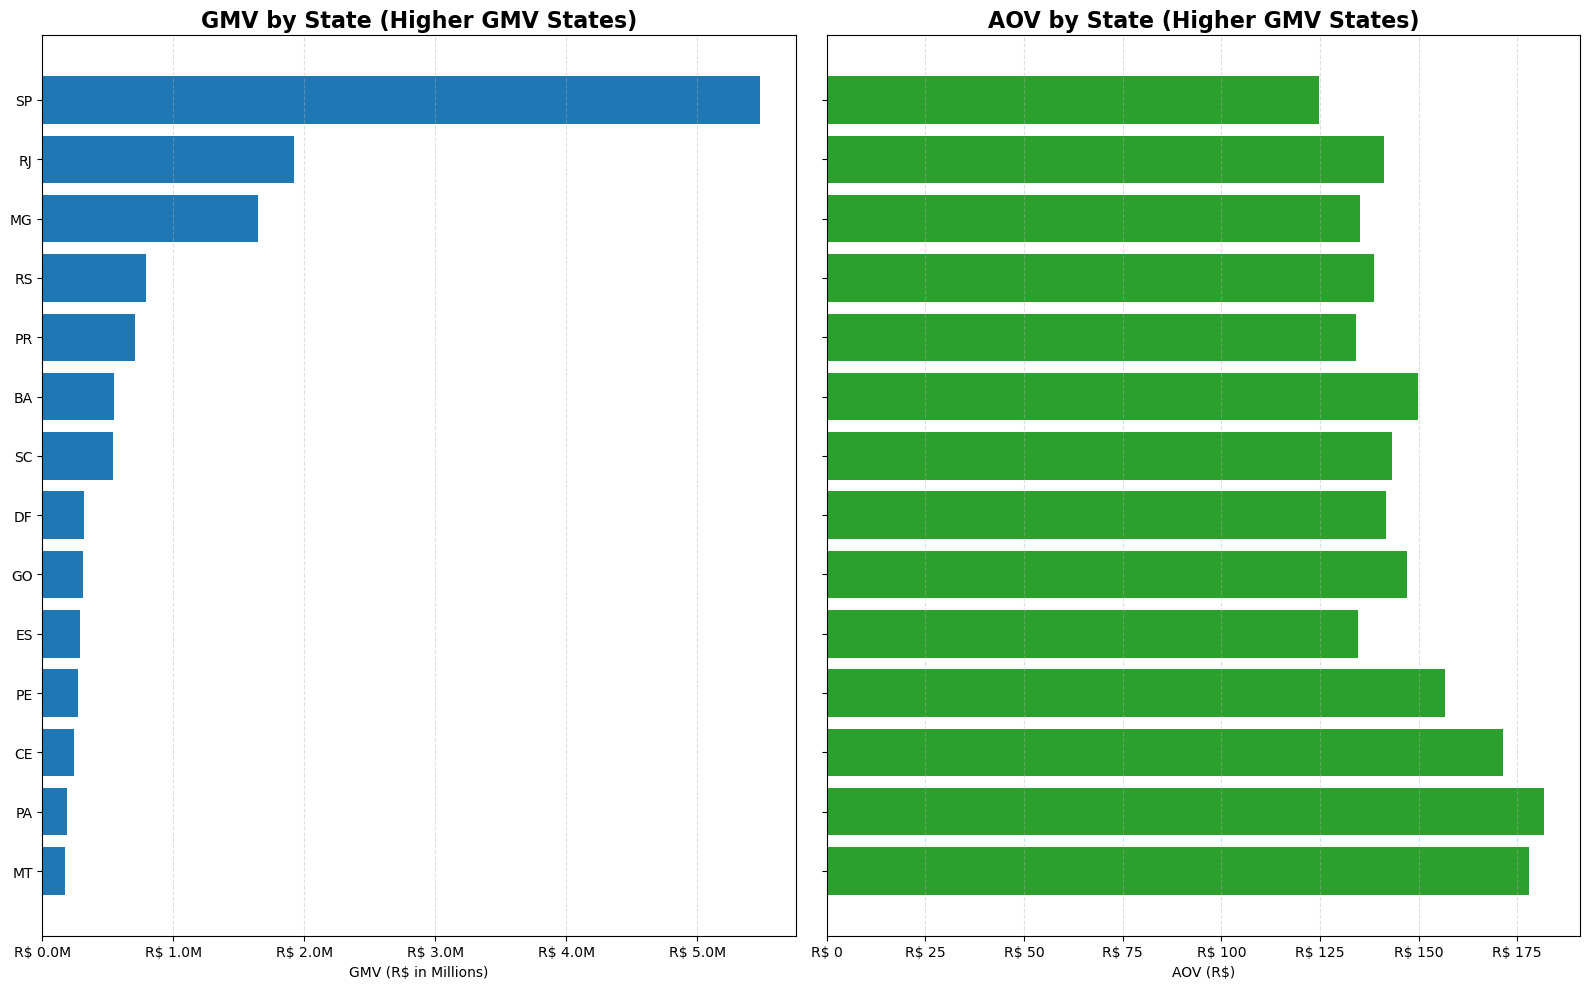

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Calculate AOV = GMV / Orders
sales_by_state["aov"] = (sales_by_state["gmv"] / sales_by_state["orders"]).round(2)

# Sort states by GMV
all_states = sales_by_state.sort_values("gmv", ascending=True)

# Split into two groups (top half and bottom half)
mid = len(all_states) // 2
group1 = all_states.iloc[:mid]    # bottom half (lower GMV states)
group2 = all_states.iloc[mid:]    # top half (higher GMV states)

# Formatters
def brl_millions(x, pos):
    return f"R$ {x/1e6:.1f}M"

def brl_plain(x, pos):
    s = f"{x:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")
    return f"R$ {s}"

# Function to plot a group
def plot_state_group(df, title_suffix):
    fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)

    # GMV
    axes[0].barh(df["customer_state"], df["gmv"], color="tab:blue")
    axes[0].set_title(f"GMV by State {title_suffix}", fontsize=16, fontweight="bold")
    axes[0].set_xlabel("GMV (R$ in Millions)")
    axes[0].xaxis.set_major_formatter(FuncFormatter(brl_millions))
    axes[0].grid(axis="x", linestyle="--", alpha=0.4)

    # AOV
    axes[1].barh(df["customer_state"], df["aov"], color="tab:green")
    axes[1].set_title(f"AOV by State {title_suffix}", fontsize=16, fontweight="bold")
    axes[1].set_xlabel("AOV (R$)")
    axes[1].xaxis.set_major_formatter(FuncFormatter(brl_plain))
    axes[1].grid(axis="x", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

# Plot first half (lower GMV states)
plot_state_group(group1, "(Lower GMV States)")

# Plot second half (higher GMV states)
plot_state_group(group2, "(Higher GMV States)")


### 6. Do customers purchase again?
Here I look at how many customers actually return to Olist to make a 2nd purchase. Turns out, **only 3% of customers actually came back**. To make it sadder, these customers spend lesser than their 1st purchase. Hence, I strongly suggest Olist to come up with a **retention strategy** focusing on customers based in South (e.g. incentivise them with a voucher to make another purchase). 

In [72]:
# Bring customer_unique_id into orders
orders_with_cust = orders.merge(
    customers[["customer_id","customer_unique_id"]],
    on="customer_id", how="left"
)

# Count orders per unique customer
cust_orders = (
    orders_with_cust.groupby("customer_unique_id", as_index=False)
    .agg(order_count=("order_id","count"))
)

# Label as Repeat or Single
cust_orders["customer_type"] = cust_orders["order_count"].apply(
    lambda x: "Repeat" if x > 1 else "Single"
)

# Merge back into orders
orders_with_cust_type = orders_with_cust.merge(
    cust_orders[["customer_unique_id","customer_type"]],
    on="customer_unique_id", how="left"
)

# Add order values (from earlier step)
orders_with_cust_type = orders_with_cust_type.merge(
    order_values, on="order_id", how="left"
)

seg_summary = (
    orders_with_cust_type.groupby("customer_type", as_index=False)
    .agg(
        customers=("customer_unique_id","nunique"),
        orders=("order_id","count"),
        gmv=("order_value","sum"),
        aov=("order_value","mean")
    )
)
seg_summary["aov"] = seg_summary["aov"].round(2)
seg_summary

,customer_type,customers,orders,gmv,aov
0,Repeat,2997,6342,778821.97,124.91
1,Single,93099,93099,12812821.73,138.62


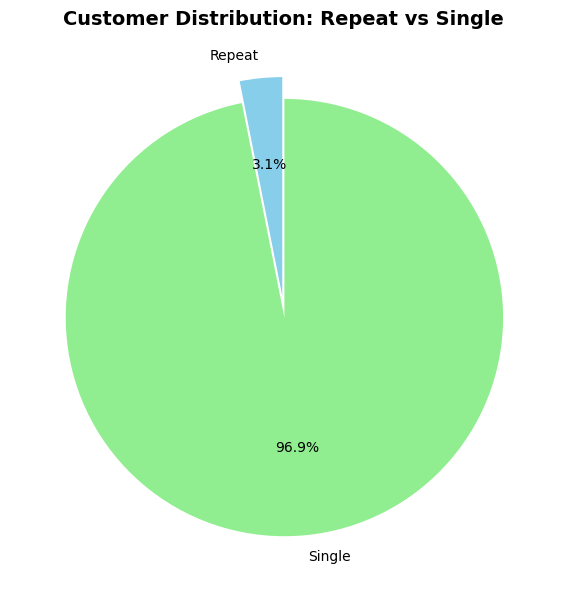

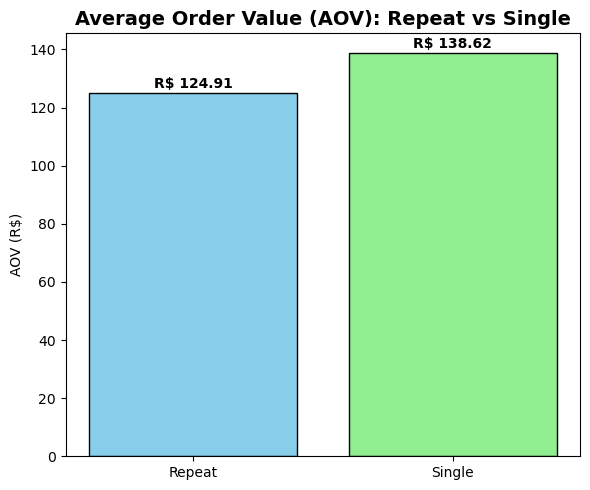

In [73]:
import matplotlib.pyplot as plt

# Pie chart: share of customers
cust_counts = seg_summary.set_index("customer_type")["customers"]

plt.figure(figsize=(6,6))
cust_counts.plot(
    kind="pie", autopct="%.1f%%", startangle=90,
    colors=["skyblue","lightgreen"], explode=[0.05,0.05]
)
plt.title("Customer Distribution: Repeat vs Single", fontsize=14, fontweight="bold")
plt.ylabel("")  # remove y-label for clean look
plt.tight_layout()
plt.show()

# Bar chart: AOV
plt.figure(figsize=(6,5))
bars = plt.bar(
    seg_summary["customer_type"],
    seg_summary["aov"],
    color=["skyblue","lightgreen"], edgecolor="black"
)

plt.title("Average Order Value (AOV): Repeat vs Single", fontsize=14, fontweight="bold")
plt.ylabel("AOV (R$)")
plt.xticks(rotation=0)

# Add labels on top of bars
for bar, val in zip(bars, seg_summary["aov"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+2,
             f"R$ {val:.2f}", ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()


### 7. When do they buy?
Here we can analyse when exactly do customers shop online. 

We found that **Mondays** are the prefered day for brazilian's customers and they tend to buy more at **afternoons**, most notably during **11am, 1pm, and 5pm.**

In [74]:
# 1) Extract weekday & hour from purchase timestamp
# Make sure purchase timestamp is datetime
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")

# Extract day of week (0=Monday, 6=Sunday)
orders["purchase_day"] = orders["order_purchase_timestamp"].dt.day_name()

# Extract hour of day (0–23)
orders["purchase_hour"] = orders["order_purchase_timestamp"].dt.hour


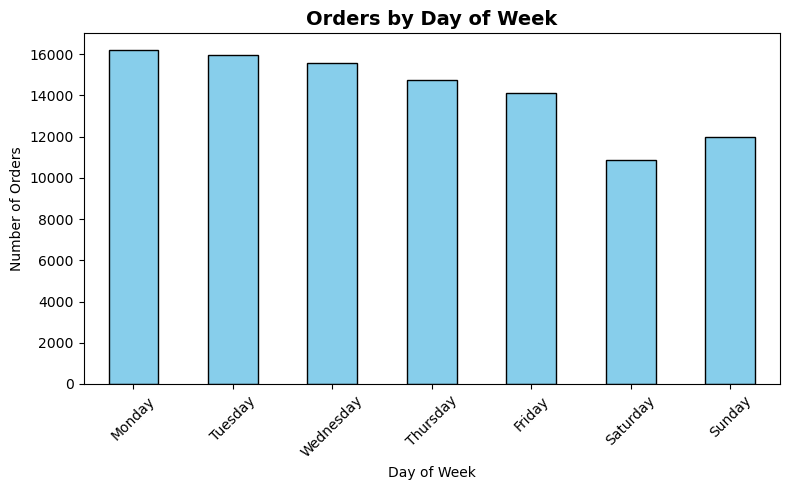

In [75]:
# 2) Check preferred day of week

day_counts = orders["purchase_day"].value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(8,5))
day_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Orders by Day of Week", fontsize=14, fontweight="bold")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


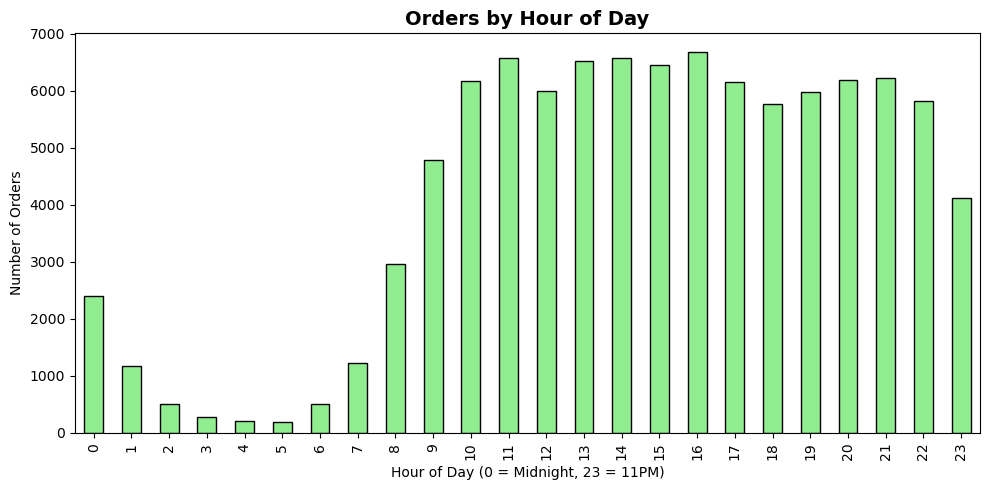

In [76]:
# 3) Check preferred hour of day

hour_counts = orders["purchase_hour"].value_counts().sort_index()

plt.figure(figsize=(10,5))
hour_counts.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Orders by Hour of Day", fontsize=14, fontweight="bold")
plt.xlabel("Hour of Day (0 = Midnight, 23 = 11PM)")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


### 8. Which product categories drive the most revenue?
`health_beauty` is the highest product category in revenue, followed by `watches_gold`.

In [ ]:
# Join product table with translations
products_translated = products.merge(
    product_category_name_translation,
    on="product_category_name",
    how="left"
)

# Use the English column when available
products_translated["category"] = products_translated["product_category_name_english"].fillna(products_translated["product_category_name"])

# Merge items with products (now with English category names)
items_with_cat = order_items.merge(
    products_translated[["product_id","category"]],
    on="product_id", how="left"
)

# Add order status for filtering
items_with_cat = items_with_cat.merge(
    orders[["order_id","order_status"]],
    on="order_id", how="left"
)

# Delivered orders only
delivered_items = items_with_cat[items_with_cat["order_status"]=="delivered"]

rev_by_cat = (
    delivered_items.groupby("category", as_index=False)
    .agg(revenue=("price","sum"))
    .sort_values("revenue", ascending=False)
)

# Convert revenue to millions
rev_by_cat["revenue_million"] = (rev_by_cat["revenue"]/1e6).round(1)

# Show top 10
top10 = rev_by_cat.head(10)

# Plot
plt.figure(figsize=(10,6))
bars = plt.barh(top10["category"], top10["revenue_million"], color="tab:blue", edgecolor="black")

plt.title("Top 10 Product Categories by Revenue", fontsize=14, fontweight="bold")
plt.xlabel("Revenue (R$ Millions)")
plt.gca().invert_yaxis()  # largest at top

plt.tight_layout()
plt.show()


### 9. Which product category has most cancellations?
`construction_tools_safety` has the highest cancellation rate followed by `construction_tools_garden` 

In [ ]:
# Flag cancellations
items_with_cat["is_cancelled"] = items_with_cat["order_status"].isin(["canceled","unavailable"])

cancel_rate = (
    items_with_cat.groupby("category", as_index=False)
    .agg(
        total_orders=("order_id","count"),
        cancelled=("is_cancelled","sum")
    )
)
cancel_rate["cancel_rate"] = (cancel_rate["cancelled"]/cancel_rate["total_orders"]*100).round(1)

# Filter out tiny categories (e.g., <100 orders)
cancel_rate_filtered = cancel_rate[cancel_rate["total_orders"]>100]
top_cancel = cancel_rate_filtered.sort_values("cancel_rate", ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
bars2 = plt.barh(top_cancel["category"], top_cancel["cancel_rate"], color="tab:red", edgecolor="black")

plt.title("Top 10 Categories by Cancellation/Unavailable Rate", fontsize=14, fontweight="bold")
plt.xlabel("Cancellation Rate (%)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


### 10) Which payment method is most used?
**Credit card** is the most used payment method followed by **Boleto**, which is a type of voucher widely used in Brazil. It allows customers to pay for goods and services without needing a bank account or credit card. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---- 0) Helper: BRL currency formatter ----
def brl_plain(x, pos):
    s = f"{x:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")
    return f"R$ {s}"

# ===========================================
# 1) Pick a PRIMARY payment type per order
#    (the row with the largest payment_value)
# ===========================================
payments_sorted = order_payments.sort_values(["order_id", "payment_value"], ascending=[True, False])
primary_pay = payments_sorted.drop_duplicates(subset="order_id", keep="first")[["order_id", "payment_type", "payment_value"]]

# Merge with order-level values (from your orders_fact table)
pay_with_value = primary_pay.merge(
    orders_fact[["order_id", "order_value"]], on="order_id", how="left"
)

# ===========================================
# 2) Payment types (bar chart: how buyers prefer to pay)
# ===========================================
type_counts = pay_with_value["payment_type"].value_counts()

plt.figure(figsize=(8,5))
bars = type_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Payment Types (Primary Method per Order)", fontsize=14, fontweight="bold")
plt.xlabel("Payment Type")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 11) Which payment type has higher order values?
**Credit card** payment recorded the highest order value, followed by boleto and debit card, while vouchers drive the smallest baskets. This makes sense as it allow **installments** unlike any other payment methods. Olist should **promote credit card installment options (3x, 6x, 12x)** to make more customers spend and increase their AOV. A **“Pay with card” tag** at checkout can also be setup to encourage larger orders. Incentivize the credit card payment method with small discounts to keep cost-conscious customers.

In [ ]:
aov_by_type = (
    pay_with_value
    .groupby("payment_type", as_index=False)
    .agg(aov=("order_value","mean"))
    .sort_values("aov", ascending=False)
)
aov_by_type["aov"] = aov_by_type["aov"].round(2)

plt.figure(figsize=(8,5))
bars2 = plt.bar(aov_by_type["payment_type"], aov_by_type["aov"], color="lightgreen", edgecolor="black")
plt.title("Average Order Value (AOV) by Payment Type", fontsize=14, fontweight="bold")
plt.xlabel("Payment Type")
plt.ylabel("AOV (R$)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(brl_plain))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# (Optional) quick table to print
aov_by_type

### 5️⃣ Data Insights